# Chap 4 : Word2Vec 속도 개선

## 다음 두 가지를 진행
- 입력층 원핫 벡터와 가중치 $W_{in}$ 간의 곱 계산에서 발생하는 문제 => Embedding 계층 도입
- 은닉층과 가중치 $W_{out}$ 간의 곱, Softmax 계층 계산에서 발생하는 문제 => Negative Sampling 도입

![ㅁㄴㅇㄹ](img/chap_04/01.png)

## 1. Em|bedding 계층
- 단어를 원핫으로의 변환과 MatMul 계층은 사실상 $W_{in}$의 특정 행을 추출하는 작업
- 단어 ID에 해당하는 행을 추출하는 계층을 통해 해결

![ㅁㄴㅇㄹ](img/chap_04/02.png)

### 1-1. Embedding 계층 구현

In [1]:
import numpy as np

W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

#### 미니배치를 고려한 행 추출

In [3]:
W[[0, 1, 3]]
# idx = np.array([0, 1, 3])
# W[idx]

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 9, 10, 11]])

### 1-2. Embedding 계층의 forward() 구현

In [4]:
class Embedding:
    def __init__(self, W):
        self.params = [W]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        self.grads = [np.zeros_like(W)]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

In [5]:
W = np.random.randn(4, 4)
W

array([[-0.63099099, -1.09679332, -0.83462609,  0.96734137],
       [-0.19876569,  0.49620227, -0.28192871,  0.02189199],
       [ 1.72665672,  0.81459993, -0.04852113, -1.47716126],
       [ 0.28738654,  1.09000282, -0.28841172, -0.57426719]])

In [6]:
embdding = Embedding(W)

embdding.forward([0, 2])

array([[-0.63099099, -1.09679332, -0.83462609,  0.96734137],
       [ 1.72665672,  0.81459993, -0.04852113, -1.47716126]])

### 1-3. Embedding 계층의 backward() 구현
- 앞 층으로부터 전해진 기울기를 가중치 기울기 $dW$의 특정 행에 설정

![ㅁㄴㅇㄹ](img/chap_04/03.png)

In [7]:
class Embedding:
    def __init__(self, W):
        self.params = [W]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        self.grads = [np.zeros_like(W)]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0  # 기울기의 형상을 유지한 상태로 0으로 초기화
        dW[self.idx] = dout
#         print("id(self.grads):", id(self.grads))
#         print("type(self.grads):", type(self.grads))
#         print(self.grads)
#         print()
#         print("id(dW):", id(dW))
#         print("type(dW):", type(dW))
#         print(dW)
        return None

In [8]:
W = np.random.randn(4, 4)
W
embdding = Embedding(W)

out = embdding.forward([0, 2])
embdding.backward(out)

### 1-4. Backward() 구현의 문제 및 해결
- idx의 원소가 중복될 경우, $dW$를 덮어쓰는 문제 발생
- 이를 해결하기 위해 해당 행의 $dW$가 존재한다면, 값을 더함(Repeat 노드의 역전파)

![ㅁㄴㅇㄹ](img/chap_04/04.png)

In [9]:
class Embedding:
    def __init__(self, W):
        self.params = [W]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        self.grads = [np.zeros_like(W)]  # 하나밖에 없지만 레이어 생성 규칙이라 배열
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0  # 기울기의 형상을 유지한 상태로 0으로 초기화
        
        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]  # Repeat 노드의 역전파 = Sum 노드
            
        # np.add.at(dW, self.idx, dout)
        
#         print("id(self.grads):", id(self.grads))
#         print("type(self.grads):", type(self.grads))
#         print(self.grads)
#         print()
#         print("id(dW):", id(dW))
#         print("type(dW):", type(dW))
#         print(dW)
        return None

In [10]:
W = np.random.randn(4, 4)
W
embdding = Embedding(W)

out = embdding.forward([0, 2])
embdding.backward(out)

## 2. Nagative sampling
- Embedding 적용후 은닉층 이후 계산이 오래 걸림
    - 은닉층 뉴런과 가중치 행렬 $W_{out}$의 곱
    - Softmax 계층 계산
- 다중 분류 => 이진분류로 근사

![ㅁㄴㅇㄹ](img/chap_04/05.png)
![ㅁㄴㅇㄹ](img/chap_04/06.png)
![ㅁㄴㅇㄹ](img/chap_04/07.png)

### 2-1. Sigmoid with Loss
- 이진 분류 문제로 변환하기 때문에 sigmoid와 Cross Entropy Error 사용

![image.png](img/chap_04/08.png)

### 2-2. 이진분류 구현
- 기존 다중분류를 수행하는 모델
![image.png](img/chap_04/09.png)

- 이진분류를 수행하는 모델
![image.png](img/chap_04/10.png)

- 은닉층 이후를 Embedding 계층과 dot 연산을 합친 Embedding Dot 계층을 이용
![image.png](img/chap_04/11.png)

#### EmbeddingDot 클래스

In [11]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)  # 기존 임베딩 계층과 동일
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None  # 순전파 계산 결과 임시 저장용
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)  # idx는 미니배치를 위해 리스트
        out = np.sum(target_W * h, axis=1)  # 각 벡터의 내적을 쉽게 구하는 트릭
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

#### SigmoidWithLoss 클래스

- Cross Entropy Error

$L = -(t\log{y} + (1 - t)\log(1-y))$

In [12]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))  # 시그모이드

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

### 2-3. Negative sampling
- 다중 분류 문제를 이진 분류 문제로 변환하였지만, 긍정적인 예만 학습
- 부정적인 예도 학습하여 모델의 분류 능력을 향상시킬 필요 있음
- 모든 부정적 예를 다 학습하는 것은 힘들고 이진 분류를 하는 이점이 없음
- 적은 수의 부정적인 예를 샘플링하여 같이 학습

![image.png](img/chap_04/12.png)
![image.png](img/chap_04/13.png)

#### 샘플링 기법
- 말뭉치에서 각 단어의 빈도수를 구하여 확률 분포로 나타냄
- 말뭉치에서 자주 등장하는 단어를 많이 추출
- 드물게 등장하는 단어를 적게 추출

In [13]:
for i in range(5):
    print(np.random.choice(10))

3
8
7
6
0


In [14]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'say'

In [15]:
np.random.choice(words, size=3)

array(['goodbye', 'goodbye', 'you'], dtype='<U7')

In [16]:
np.random.choice(words, size=3, replace=False)  # 중복 없음

array(['.', 'hello', 'say'], dtype='<U7')

In [17]:
data = np.random.randn(6)
data

array([-0.68821179, -0.88381586, -0.46358765,  1.75315678,  0.4147093 ,
        1.40682421])

In [18]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [19]:
p = softmax(data)
p

array([0.03890804, 0.03199555, 0.04870711, 0.44700483, 0.11722814,
       0.31615634])

In [20]:
np.random.choice(words, p=p)

'I'

#### word2vec 네거티브 샘플링은 확률분포에 0.75를 곱할 것을 권고
- 출현이 낮은 단어를 버리지 않기 위해 사용
- 확률이 낮은 단어의 확률을 좀 높여, 샘플링될 확률을 올려줌

$P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_{j}^{n}{P(w_j)^{0.75}}}$

In [21]:
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)

[(i, j) for i, j in zip(p, new_p)]

[(0.03890803683048337, 0.061023963507918104),
 (0.03199554773871647, 0.05269726610730377),
 (0.04870710775871456, 0.0722212796664654),
 (0.4470048330253425, 0.3808071438049258),
 (0.11722813672016272, 0.13955481313206763),
 (0.3161563379265803, 0.2936955337813193)]

### 2-4 부정적 예를 샘플링하는 클래스

In [22]:
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)  # 원하는 샘플 크기만큼 제로 배열 생성

        for i in range(batch_size):  # 배치만큼 반복
            p = self.word_p.copy()  # 기존 데이터 없어지지 않게 복사
            target_idx = target[i]
            p[target_idx] = 0  # 타겟의 인덱스는 선택되지 않도록 고정
            p /= p.sum()  # 각 샘플 수에 합으로 나눠주어 확률분포를 구함
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)  # 샘플개수만큼 선택

        return negative_sample

In [23]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[4, 2],
       [4, 0],
       [2, 4]])

### 2-5 NegativeSampling 구현

In [24]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]  # _를 사용한 이유는 단순히 샘플수+1(긍정)만큼 SigmoidWithLoss를 인스턴스화 하기 위해
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]  # 행의 개수 = 배치 크기
        negative_sample = self.sampler.get_negative_sample(target)  # 부정적 샘플 추출

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)  # 0번째 레이어가 긍정에 사용하는 레이어(부정을 한번에 연산하기 위해 편의상)
        correct_label = np.ones(batch_size, dtype=np.int32)  # 정답이라 ones 사용
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)  # 오답이라 zeros 사용
        for i in range(self.sample_size):  # 샘플이 2라면, 각 오답 샘플에 대해 순전파
            negative_target = negative_sample[:, i]  # 하나의 샘플을 가져옴
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)  # SigmoidWithLoss의 역전파(정답과 출력의 차)
            dh += l1.backward(dscore)  # EmbeddingDot의 역전파(Repeat노드의 역전파 = Sum 노드)

        return dh

## 3. 개선된 CBOW 모델 구현

In [25]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):  # 윈도우 사이즈가 고려되어 2배
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        self.word_out_vecs = W_out
        

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # 평균
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)  # 평균을 곱했기 때문에 평균값을 역전파로 흘려보냄
        for layer in self.in_layers:
            layer.backward(dout)
        return None


![image.png](img/chap_04/10.png)

### 3-1. CBOW 학습
- 기존의 원핫 벡터를 단어의 index로 받는 점이 달라짐
- context는 2차원, ratget은 1차원 배열

![image.png](img/chap_04/14.png)

In [26]:
from dataset import ptb
from common.util import create_contexts_target, to_cpu, to_gpu
import pickle
from common.trainer import Trainer
from common.optimizer import Adam


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
out_vecs = model.word_out_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 5[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 8[s] | 손실 3.94
| 에폭 1 |  반복 121 / 9295 | 시간 10[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 손실 3.64
| 에폭 1 |  반복 161 / 9295 | 시간 13[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 15[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 17[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 18[s] | 손실 3.15
| 에폭 1 |  반복 241 / 9295 | 시간 20[s] | 손실 3.10
| 에폭 1 |  반복 261 / 9295 | 시간 22[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 24[s] | 손실 2.94
| 에폭 1 |  반복 301 / 9295 | 시간 25[s] | 손실 2.91
| 에폭 1 |  반복 321 / 9295 | 시간 27[s] | 손실 2.84
| 에폭 1 |  반복 341 / 9295 | 시간 29[s] | 손실 2.84
| 에폭 1 |  반복 361 / 9295 | 시간 31[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 32[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 34[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 36[s] | 손실 2.76
| 에폭 1 |  반복 441 / 929

| 에폭 1 |  반복 3541 / 9295 | 시간 302[s] | 손실 2.41
| 에폭 1 |  반복 3561 / 9295 | 시간 303[s] | 손실 2.44
| 에폭 1 |  반복 3581 / 9295 | 시간 305[s] | 손실 2.41
| 에폭 1 |  반복 3601 / 9295 | 시간 307[s] | 손실 2.41
| 에폭 1 |  반복 3621 / 9295 | 시간 308[s] | 손실 2.42
| 에폭 1 |  반복 3641 / 9295 | 시간 310[s] | 손실 2.47
| 에폭 1 |  반복 3661 / 9295 | 시간 312[s] | 손실 2.41
| 에폭 1 |  반복 3681 / 9295 | 시간 313[s] | 손실 2.41
| 에폭 1 |  반복 3701 / 9295 | 시간 315[s] | 손실 2.41
| 에폭 1 |  반복 3721 / 9295 | 시간 317[s] | 손실 2.39
| 에폭 1 |  반복 3741 / 9295 | 시간 318[s] | 손실 2.38
| 에폭 1 |  반복 3761 / 9295 | 시간 320[s] | 손실 2.40
| 에폭 1 |  반복 3781 / 9295 | 시간 322[s] | 손실 2.40
| 에폭 1 |  반복 3801 / 9295 | 시간 323[s] | 손실 2.41
| 에폭 1 |  반복 3821 / 9295 | 시간 325[s] | 손실 2.41
| 에폭 1 |  반복 3841 / 9295 | 시간 327[s] | 손실 2.41
| 에폭 1 |  반복 3861 / 9295 | 시간 328[s] | 손실 2.44
| 에폭 1 |  반복 3881 / 9295 | 시간 330[s] | 손실 2.42
| 에폭 1 |  반복 3901 / 9295 | 시간 332[s] | 손실 2.39
| 에폭 1 |  반복 3921 / 9295 | 시간 333[s] | 손실 2.37
| 에폭 1 |  반복 3941 / 9295 | 시간 335[s] | 손실 2.40
| 에폭 1 |  반복 

| 에폭 1 |  반복 7041 / 9295 | 시간 596[s] | 손실 2.27
| 에폭 1 |  반복 7061 / 9295 | 시간 598[s] | 손실 2.27
| 에폭 1 |  반복 7081 / 9295 | 시간 600[s] | 손실 2.29
| 에폭 1 |  반복 7101 / 9295 | 시간 601[s] | 손실 2.29
| 에폭 1 |  반복 7121 / 9295 | 시간 603[s] | 손실 2.27
| 에폭 1 |  반복 7141 / 9295 | 시간 604[s] | 손실 2.26
| 에폭 1 |  반복 7161 / 9295 | 시간 606[s] | 손실 2.29
| 에폭 1 |  반복 7181 / 9295 | 시간 608[s] | 손실 2.29
| 에폭 1 |  반복 7201 / 9295 | 시간 609[s] | 손실 2.26
| 에폭 1 |  반복 7221 / 9295 | 시간 611[s] | 손실 2.27
| 에폭 1 |  반복 7241 / 9295 | 시간 613[s] | 손실 2.24
| 에폭 1 |  반복 7261 / 9295 | 시간 614[s] | 손실 2.25
| 에폭 1 |  반복 7281 / 9295 | 시간 616[s] | 손실 2.25
| 에폭 1 |  반복 7301 / 9295 | 시간 618[s] | 손실 2.27
| 에폭 1 |  반복 7321 / 9295 | 시간 619[s] | 손실 2.28
| 에폭 1 |  반복 7341 / 9295 | 시간 621[s] | 손실 2.29
| 에폭 1 |  반복 7361 / 9295 | 시간 623[s] | 손실 2.28
| 에폭 1 |  반복 7381 / 9295 | 시간 624[s] | 손실 2.27
| 에폭 1 |  반복 7401 / 9295 | 시간 626[s] | 손실 2.26
| 에폭 1 |  반복 7421 / 9295 | 시간 628[s] | 손실 2.26
| 에폭 1 |  반복 7441 / 9295 | 시간 630[s] | 손실 2.27
| 에폭 1 |  반복 

| 에폭 2 |  반복 1261 / 9295 | 시간 896[s] | 손실 2.15
| 에폭 2 |  반복 1281 / 9295 | 시간 898[s] | 손실 2.12
| 에폭 2 |  반복 1301 / 9295 | 시간 900[s] | 손실 2.16
| 에폭 2 |  반복 1321 / 9295 | 시간 902[s] | 손실 2.16
| 에폭 2 |  반복 1341 / 9295 | 시간 904[s] | 손실 2.18
| 에폭 2 |  반복 1361 / 9295 | 시간 905[s] | 손실 2.15
| 에폭 2 |  반복 1381 / 9295 | 시간 907[s] | 손실 2.15
| 에폭 2 |  반복 1401 / 9295 | 시간 909[s] | 손실 2.16
| 에폭 2 |  반복 1421 / 9295 | 시간 910[s] | 손실 2.12
| 에폭 2 |  반복 1441 / 9295 | 시간 912[s] | 손실 2.18
| 에폭 2 |  반복 1461 / 9295 | 시간 914[s] | 손실 2.13
| 에폭 2 |  반복 1481 / 9295 | 시간 915[s] | 손실 2.14
| 에폭 2 |  반복 1501 / 9295 | 시간 917[s] | 손실 2.17
| 에폭 2 |  반복 1521 / 9295 | 시간 919[s] | 손실 2.15
| 에폭 2 |  반복 1541 / 9295 | 시간 920[s] | 손실 2.12
| 에폭 2 |  반복 1561 / 9295 | 시간 922[s] | 손실 2.13
| 에폭 2 |  반복 1581 / 9295 | 시간 924[s] | 손실 2.19
| 에폭 2 |  반복 1601 / 9295 | 시간 925[s] | 손실 2.14
| 에폭 2 |  반복 1621 / 9295 | 시간 927[s] | 손실 2.13
| 에폭 2 |  반복 1641 / 9295 | 시간 929[s] | 손실 2.13
| 에폭 2 |  반복 1661 / 9295 | 시간 930[s] | 손실 2.17
| 에폭 2 |  반복 

| 에폭 2 |  반복 4701 / 9295 | 시간 1186[s] | 손실 2.09
| 에폭 2 |  반복 4721 / 9295 | 시간 1188[s] | 손실 2.09
| 에폭 2 |  반복 4741 / 9295 | 시간 1189[s] | 손실 2.09
| 에폭 2 |  반복 4761 / 9295 | 시간 1191[s] | 손실 2.09
| 에폭 2 |  반복 4781 / 9295 | 시간 1193[s] | 손실 2.12
| 에폭 2 |  반복 4801 / 9295 | 시간 1194[s] | 손실 2.11
| 에폭 2 |  반복 4821 / 9295 | 시간 1196[s] | 손실 2.13
| 에폭 2 |  반복 4841 / 9295 | 시간 1198[s] | 손실 2.11
| 에폭 2 |  반복 4861 / 9295 | 시간 1199[s] | 손실 2.09
| 에폭 2 |  반복 4881 / 9295 | 시간 1201[s] | 손실 2.05
| 에폭 2 |  반복 4901 / 9295 | 시간 1203[s] | 손실 2.08
| 에폭 2 |  반복 4921 / 9295 | 시간 1205[s] | 손실 2.07
| 에폭 2 |  반복 4941 / 9295 | 시간 1206[s] | 손실 2.09
| 에폭 2 |  반복 4961 / 9295 | 시간 1208[s] | 손실 2.10
| 에폭 2 |  반복 4981 / 9295 | 시간 1210[s] | 손실 2.09
| 에폭 2 |  반복 5001 / 9295 | 시간 1211[s] | 손실 2.05
| 에폭 2 |  반복 5021 / 9295 | 시간 1213[s] | 손실 2.07
| 에폭 2 |  반복 5041 / 9295 | 시간 1215[s] | 손실 2.10
| 에폭 2 |  반복 5061 / 9295 | 시간 1216[s] | 손실 2.07
| 에폭 2 |  반복 5081 / 9295 | 시간 1218[s] | 손실 2.06
| 에폭 2 |  반복 5101 / 9295 | 시간 1220[s] | 

| 에폭 2 |  반복 8121 / 9295 | 시간 1478[s] | 손실 2.03
| 에폭 2 |  반복 8141 / 9295 | 시간 1479[s] | 손실 2.04
| 에폭 2 |  반복 8161 / 9295 | 시간 1481[s] | 손실 2.01
| 에폭 2 |  반복 8181 / 9295 | 시간 1482[s] | 손실 2.00
| 에폭 2 |  반복 8201 / 9295 | 시간 1484[s] | 손실 2.06
| 에폭 2 |  반복 8221 / 9295 | 시간 1486[s] | 손실 2.05
| 에폭 2 |  반복 8241 / 9295 | 시간 1487[s] | 손실 1.98
| 에폭 2 |  반복 8261 / 9295 | 시간 1489[s] | 손실 1.98
| 에폭 2 |  반복 8281 / 9295 | 시간 1491[s] | 손실 2.03
| 에폭 2 |  반복 8301 / 9295 | 시간 1492[s] | 손실 2.08
| 에폭 2 |  반복 8321 / 9295 | 시간 1494[s] | 손실 2.05
| 에폭 2 |  반복 8341 / 9295 | 시간 1496[s] | 손실 2.03
| 에폭 2 |  반복 8361 / 9295 | 시간 1497[s] | 손실 2.08
| 에폭 2 |  반복 8381 / 9295 | 시간 1499[s] | 손실 2.05
| 에폭 2 |  반복 8401 / 9295 | 시간 1501[s] | 손실 2.05
| 에폭 2 |  반복 8421 / 9295 | 시간 1502[s] | 손실 2.05
| 에폭 2 |  반복 8441 / 9295 | 시간 1504[s] | 손실 2.03
| 에폭 2 |  반복 8461 / 9295 | 시간 1506[s] | 손실 2.00
| 에폭 2 |  반복 8481 / 9295 | 시간 1507[s] | 손실 2.04
| 에폭 2 |  반복 8501 / 9295 | 시간 1509[s] | 손실 2.02
| 에폭 2 |  반복 8521 / 9295 | 시간 1511[s] | 

| 에폭 3 |  반복 2261 / 9295 | 시간 1778[s] | 손실 1.95
| 에폭 3 |  반복 2281 / 9295 | 시간 1780[s] | 손실 1.93
| 에폭 3 |  반복 2301 / 9295 | 시간 1782[s] | 손실 1.91
| 에폭 3 |  반복 2321 / 9295 | 시간 1783[s] | 손실 1.93
| 에폭 3 |  반복 2341 / 9295 | 시간 1785[s] | 손실 1.93
| 에폭 3 |  반복 2361 / 9295 | 시간 1787[s] | 손실 1.93
| 에폭 3 |  반복 2381 / 9295 | 시간 1788[s] | 손실 1.95
| 에폭 3 |  반복 2401 / 9295 | 시간 1790[s] | 손실 1.97
| 에폭 3 |  반복 2421 / 9295 | 시간 1792[s] | 손실 1.92
| 에폭 3 |  반복 2441 / 9295 | 시간 1793[s] | 손실 1.93
| 에폭 3 |  반복 2461 / 9295 | 시간 1795[s] | 손실 1.97
| 에폭 3 |  반복 2481 / 9295 | 시간 1797[s] | 손실 1.94
| 에폭 3 |  반복 2501 / 9295 | 시간 1798[s] | 손실 1.97
| 에폭 3 |  반복 2521 / 9295 | 시간 1800[s] | 손실 1.96
| 에폭 3 |  반복 2541 / 9295 | 시간 1802[s] | 손실 1.92
| 에폭 3 |  반복 2561 / 9295 | 시간 1803[s] | 손실 1.95
| 에폭 3 |  반복 2581 / 9295 | 시간 1805[s] | 손실 1.92
| 에폭 3 |  반복 2601 / 9295 | 시간 1807[s] | 손실 1.91
| 에폭 3 |  반복 2621 / 9295 | 시간 1808[s] | 손실 1.99
| 에폭 3 |  반복 2641 / 9295 | 시간 1810[s] | 손실 1.90
| 에폭 3 |  반복 2661 / 9295 | 시간 1812[s] | 

| 에폭 3 |  반복 5681 / 9295 | 시간 2080[s] | 손실 1.92
| 에폭 3 |  반복 5701 / 9295 | 시간 2082[s] | 손실 1.95
| 에폭 3 |  반복 5721 / 9295 | 시간 2084[s] | 손실 1.96
| 에폭 3 |  반복 5741 / 9295 | 시간 2086[s] | 손실 1.92
| 에폭 3 |  반복 5761 / 9295 | 시간 2088[s] | 손실 1.93
| 에폭 3 |  반복 5781 / 9295 | 시간 2090[s] | 손실 1.95
| 에폭 3 |  반복 5801 / 9295 | 시간 2091[s] | 손실 1.88
| 에폭 3 |  반복 5821 / 9295 | 시간 2093[s] | 손실 1.91
| 에폭 3 |  반복 5841 / 9295 | 시간 2095[s] | 손실 1.90
| 에폭 3 |  반복 5861 / 9295 | 시간 2097[s] | 손실 1.95
| 에폭 3 |  반복 5881 / 9295 | 시간 2098[s] | 손실 1.91
| 에폭 3 |  반복 5901 / 9295 | 시간 2100[s] | 손실 1.92
| 에폭 3 |  반복 5921 / 9295 | 시간 2102[s] | 손실 1.92
| 에폭 3 |  반복 5941 / 9295 | 시간 2103[s] | 손실 1.93
| 에폭 3 |  반복 5961 / 9295 | 시간 2105[s] | 손실 1.91
| 에폭 3 |  반복 5981 / 9295 | 시간 2107[s] | 손실 1.89
| 에폭 3 |  반복 6001 / 9295 | 시간 2108[s] | 손실 1.90
| 에폭 3 |  반복 6021 / 9295 | 시간 2110[s] | 손실 1.93
| 에폭 3 |  반복 6041 / 9295 | 시간 2112[s] | 손실 1.91
| 에폭 3 |  반복 6061 / 9295 | 시간 2113[s] | 손실 1.95
| 에폭 3 |  반복 6081 / 9295 | 시간 2115[s] | 

| 에폭 3 |  반복 9101 / 9295 | 시간 2402[s] | 손실 1.89
| 에폭 3 |  반복 9121 / 9295 | 시간 2403[s] | 손실 1.88
| 에폭 3 |  반복 9141 / 9295 | 시간 2405[s] | 손실 1.88
| 에폭 3 |  반복 9161 / 9295 | 시간 2407[s] | 손실 1.88
| 에폭 3 |  반복 9181 / 9295 | 시간 2408[s] | 손실 1.86
| 에폭 3 |  반복 9201 / 9295 | 시간 2410[s] | 손실 1.89
| 에폭 3 |  반복 9221 / 9295 | 시간 2412[s] | 손실 1.90
| 에폭 3 |  반복 9241 / 9295 | 시간 2413[s] | 손실 1.86
| 에폭 3 |  반복 9261 / 9295 | 시간 2415[s] | 손실 1.86
| 에폭 3 |  반복 9281 / 9295 | 시간 2417[s] | 손실 1.91
| 에폭 4 |  반복 1 / 9295 | 시간 2418[s] | 손실 1.92
| 에폭 4 |  반복 21 / 9295 | 시간 2420[s] | 손실 1.82
| 에폭 4 |  반복 41 / 9295 | 시간 2421[s] | 손실 1.83
| 에폭 4 |  반복 61 / 9295 | 시간 2423[s] | 손실 1.84
| 에폭 4 |  반복 81 / 9295 | 시간 2425[s] | 손실 1.81
| 에폭 4 |  반복 101 / 9295 | 시간 2426[s] | 손실 1.82
| 에폭 4 |  반복 121 / 9295 | 시간 2428[s] | 손실 1.86
| 에폭 4 |  반복 141 / 9295 | 시간 2430[s] | 손실 1.83
| 에폭 4 |  반복 161 / 9295 | 시간 2432[s] | 손실 1.82
| 에폭 4 |  반복 181 / 9295 | 시간 2433[s] | 손실 1.78
| 에폭 4 |  반복 201 / 9295 | 시간 2435[s] | 손실 1.87
| 에폭 4 | 

| 에폭 4 |  반복 3241 / 9295 | 시간 2724[s] | 손실 1.85
| 에폭 4 |  반복 3261 / 9295 | 시간 2726[s] | 손실 1.80
| 에폭 4 |  반복 3281 / 9295 | 시간 2727[s] | 손실 1.83
| 에폭 4 |  반복 3301 / 9295 | 시간 2729[s] | 손실 1.83
| 에폭 4 |  반복 3321 / 9295 | 시간 2731[s] | 손실 1.84
| 에폭 4 |  반복 3341 / 9295 | 시간 2733[s] | 손실 1.84
| 에폭 4 |  반복 3361 / 9295 | 시간 2735[s] | 손실 1.81
| 에폭 4 |  반복 3381 / 9295 | 시간 2736[s] | 손실 1.82
| 에폭 4 |  반복 3401 / 9295 | 시간 2738[s] | 손실 1.82
| 에폭 4 |  반복 3421 / 9295 | 시간 2740[s] | 손실 1.81
| 에폭 4 |  반복 3441 / 9295 | 시간 2742[s] | 손실 1.80
| 에폭 4 |  반복 3461 / 9295 | 시간 2743[s] | 손실 1.83
| 에폭 4 |  반복 3481 / 9295 | 시간 2745[s] | 손실 1.81
| 에폭 4 |  반복 3501 / 9295 | 시간 2747[s] | 손실 1.83
| 에폭 4 |  반복 3521 / 9295 | 시간 2749[s] | 손실 1.80
| 에폭 4 |  반복 3541 / 9295 | 시간 2750[s] | 손실 1.81
| 에폭 4 |  반복 3561 / 9295 | 시간 2752[s] | 손실 1.83
| 에폭 4 |  반복 3581 / 9295 | 시간 2754[s] | 손실 1.81
| 에폭 4 |  반복 3601 / 9295 | 시간 2755[s] | 손실 1.79
| 에폭 4 |  반복 3621 / 9295 | 시간 2757[s] | 손실 1.83
| 에폭 4 |  반복 3641 / 9295 | 시간 2759[s] | 

| 에폭 4 |  반복 6661 / 9295 | 시간 3032[s] | 손실 1.78
| 에폭 4 |  반복 6681 / 9295 | 시간 3033[s] | 손실 1.78
| 에폭 4 |  반복 6701 / 9295 | 시간 3035[s] | 손실 1.79
| 에폭 4 |  반복 6721 / 9295 | 시간 3037[s] | 손실 1.80
| 에폭 4 |  반복 6741 / 9295 | 시간 3039[s] | 손실 1.83
| 에폭 4 |  반복 6761 / 9295 | 시간 3040[s] | 손실 1.80
| 에폭 4 |  반복 6781 / 9295 | 시간 3042[s] | 손실 1.76
| 에폭 4 |  반복 6801 / 9295 | 시간 3044[s] | 손실 1.81
| 에폭 4 |  반복 6821 / 9295 | 시간 3046[s] | 손실 1.80
| 에폭 4 |  반복 6841 / 9295 | 시간 3048[s] | 손실 1.77
| 에폭 4 |  반복 6861 / 9295 | 시간 3049[s] | 손실 1.81
| 에폭 4 |  반복 6881 / 9295 | 시간 3051[s] | 손실 1.80
| 에폭 4 |  반복 6901 / 9295 | 시간 3053[s] | 손실 1.83
| 에폭 4 |  반복 6921 / 9295 | 시간 3054[s] | 손실 1.84
| 에폭 4 |  반복 6941 / 9295 | 시간 3056[s] | 손실 1.76
| 에폭 4 |  반복 6961 / 9295 | 시간 3058[s] | 손실 1.78
| 에폭 4 |  반복 6981 / 9295 | 시간 3059[s] | 손실 1.76
| 에폭 4 |  반복 7001 / 9295 | 시간 3061[s] | 손실 1.82
| 에폭 4 |  반복 7021 / 9295 | 시간 3063[s] | 손실 1.75
| 에폭 4 |  반복 7041 / 9295 | 시간 3066[s] | 손실 1.84
| 에폭 4 |  반복 7061 / 9295 | 시간 3067[s] | 

| 에폭 5 |  반복 801 / 9295 | 시간 3330[s] | 손실 1.71
| 에폭 5 |  반복 821 / 9295 | 시간 3332[s] | 손실 1.72
| 에폭 5 |  반복 841 / 9295 | 시간 3334[s] | 손실 1.77
| 에폭 5 |  반복 861 / 9295 | 시간 3336[s] | 손실 1.75
| 에폭 5 |  반복 881 / 9295 | 시간 3337[s] | 손실 1.70
| 에폭 5 |  반복 901 / 9295 | 시간 3339[s] | 손실 1.75
| 에폭 5 |  반복 921 / 9295 | 시간 3341[s] | 손실 1.67
| 에폭 5 |  반복 941 / 9295 | 시간 3342[s] | 손실 1.70
| 에폭 5 |  반복 961 / 9295 | 시간 3344[s] | 손실 1.71
| 에폭 5 |  반복 981 / 9295 | 시간 3346[s] | 손실 1.77
| 에폭 5 |  반복 1001 / 9295 | 시간 3347[s] | 손실 1.77
| 에폭 5 |  반복 1021 / 9295 | 시간 3349[s] | 손실 1.76
| 에폭 5 |  반복 1041 / 9295 | 시간 3351[s] | 손실 1.71
| 에폭 5 |  반복 1061 / 9295 | 시간 3352[s] | 손실 1.73
| 에폭 5 |  반복 1081 / 9295 | 시간 3354[s] | 손실 1.69
| 에폭 5 |  반복 1101 / 9295 | 시간 3356[s] | 손실 1.75
| 에폭 5 |  반복 1121 / 9295 | 시간 3357[s] | 손실 1.72
| 에폭 5 |  반복 1141 / 9295 | 시간 3359[s] | 손실 1.71
| 에폭 5 |  반복 1161 / 9295 | 시간 3361[s] | 손실 1.74
| 에폭 5 |  반복 1181 / 9295 | 시간 3362[s] | 손실 1.72
| 에폭 5 |  반복 1201 / 9295 | 시간 3364[s] | 손실 1.74
| 

| 에폭 5 |  반복 4221 / 9295 | 시간 3626[s] | 손실 1.68
| 에폭 5 |  반복 4241 / 9295 | 시간 3628[s] | 손실 1.71
| 에폭 5 |  반복 4261 / 9295 | 시간 3630[s] | 손실 1.76
| 에폭 5 |  반복 4281 / 9295 | 시간 3632[s] | 손실 1.73
| 에폭 5 |  반복 4301 / 9295 | 시간 3633[s] | 손실 1.74
| 에폭 5 |  반복 4321 / 9295 | 시간 3635[s] | 손실 1.73
| 에폭 5 |  반복 4341 / 9295 | 시간 3637[s] | 손실 1.71
| 에폭 5 |  반복 4361 / 9295 | 시간 3638[s] | 손실 1.71
| 에폭 5 |  반복 4381 / 9295 | 시간 3640[s] | 손실 1.75
| 에폭 5 |  반복 4401 / 9295 | 시간 3642[s] | 손실 1.71
| 에폭 5 |  반복 4421 / 9295 | 시간 3643[s] | 손실 1.72
| 에폭 5 |  반복 4441 / 9295 | 시간 3645[s] | 손실 1.73
| 에폭 5 |  반복 4461 / 9295 | 시간 3647[s] | 손실 1.74
| 에폭 5 |  반복 4481 / 9295 | 시간 3649[s] | 손실 1.74
| 에폭 5 |  반복 4501 / 9295 | 시간 3651[s] | 손실 1.74
| 에폭 5 |  반복 4521 / 9295 | 시간 3652[s] | 손실 1.70
| 에폭 5 |  반복 4541 / 9295 | 시간 3654[s] | 손실 1.75
| 에폭 5 |  반복 4561 / 9295 | 시간 3656[s] | 손실 1.73
| 에폭 5 |  반복 4581 / 9295 | 시간 3657[s] | 손실 1.74
| 에폭 5 |  반복 4601 / 9295 | 시간 3659[s] | 손실 1.70
| 에폭 5 |  반복 4621 / 9295 | 시간 3661[s] | 

| 에폭 5 |  반복 7641 / 9295 | 시간 3934[s] | 손실 1.71
| 에폭 5 |  반복 7661 / 9295 | 시간 3937[s] | 손실 1.75
| 에폭 5 |  반복 7681 / 9295 | 시간 3938[s] | 손실 1.69
| 에폭 5 |  반복 7701 / 9295 | 시간 3940[s] | 손실 1.71
| 에폭 5 |  반복 7721 / 9295 | 시간 3942[s] | 손실 1.70
| 에폭 5 |  반복 7741 / 9295 | 시간 3943[s] | 손실 1.75
| 에폭 5 |  반복 7761 / 9295 | 시간 3945[s] | 손실 1.70
| 에폭 5 |  반복 7781 / 9295 | 시간 3947[s] | 손실 1.70
| 에폭 5 |  반복 7801 / 9295 | 시간 3949[s] | 손실 1.69
| 에폭 5 |  반복 7821 / 9295 | 시간 3950[s] | 손실 1.74
| 에폭 5 |  반복 7841 / 9295 | 시간 3952[s] | 손실 1.77
| 에폭 5 |  반복 7861 / 9295 | 시간 3954[s] | 손실 1.70
| 에폭 5 |  반복 7881 / 9295 | 시간 3955[s] | 손실 1.73
| 에폭 5 |  반복 7901 / 9295 | 시간 3957[s] | 손실 1.71
| 에폭 5 |  반복 7921 / 9295 | 시간 3959[s] | 손실 1.70
| 에폭 5 |  반복 7941 / 9295 | 시간 3961[s] | 손실 1.70
| 에폭 5 |  반복 7961 / 9295 | 시간 3964[s] | 손실 1.72
| 에폭 5 |  반복 7981 / 9295 | 시간 3966[s] | 손실 1.72
| 에폭 5 |  반복 8001 / 9295 | 시간 3968[s] | 손실 1.73
| 에폭 5 |  반복 8021 / 9295 | 시간 3970[s] | 손실 1.74
| 에폭 5 |  반복 8041 / 9295 | 시간 3972[s] | 

| 에폭 6 |  반복 1781 / 9295 | 시간 4232[s] | 손실 1.67
| 에폭 6 |  반복 1801 / 9295 | 시간 4234[s] | 손실 1.68
| 에폭 6 |  반복 1821 / 9295 | 시간 4236[s] | 손실 1.69
| 에폭 6 |  반복 1841 / 9295 | 시간 4237[s] | 손실 1.65
| 에폭 6 |  반복 1861 / 9295 | 시간 4239[s] | 손실 1.64
| 에폭 6 |  반복 1881 / 9295 | 시간 4241[s] | 손실 1.64
| 에폭 6 |  반복 1901 / 9295 | 시간 4242[s] | 손실 1.63
| 에폭 6 |  반복 1921 / 9295 | 시간 4244[s] | 손실 1.63
| 에폭 6 |  반복 1941 / 9295 | 시간 4246[s] | 손실 1.66
| 에폭 6 |  반복 1961 / 9295 | 시간 4247[s] | 손실 1.69
| 에폭 6 |  반복 1981 / 9295 | 시간 4249[s] | 손실 1.66
| 에폭 6 |  반복 2001 / 9295 | 시간 4251[s] | 손실 1.64
| 에폭 6 |  반복 2021 / 9295 | 시간 4252[s] | 손실 1.63
| 에폭 6 |  반복 2041 / 9295 | 시간 4254[s] | 손실 1.68
| 에폭 6 |  반복 2061 / 9295 | 시간 4256[s] | 손실 1.57
| 에폭 6 |  반복 2081 / 9295 | 시간 4258[s] | 손실 1.69
| 에폭 6 |  반복 2101 / 9295 | 시간 4260[s] | 손실 1.67
| 에폭 6 |  반복 2121 / 9295 | 시간 4261[s] | 손실 1.63
| 에폭 6 |  반복 2141 / 9295 | 시간 4263[s] | 손실 1.67
| 에폭 6 |  반복 2161 / 9295 | 시간 4265[s] | 손실 1.60
| 에폭 6 |  반복 2181 / 9295 | 시간 4267[s] | 

| 에폭 6 |  반복 5201 / 9295 | 시간 4524[s] | 손실 1.67
| 에폭 6 |  반복 5221 / 9295 | 시간 4525[s] | 손실 1.62
| 에폭 6 |  반복 5241 / 9295 | 시간 4527[s] | 손실 1.65
| 에폭 6 |  반복 5261 / 9295 | 시간 4529[s] | 손실 1.66
| 에폭 6 |  반복 5281 / 9295 | 시간 4530[s] | 손실 1.61
| 에폭 6 |  반복 5301 / 9295 | 시간 4532[s] | 손실 1.62
| 에폭 6 |  반복 5321 / 9295 | 시간 4534[s] | 손실 1.64
| 에폭 6 |  반복 5341 / 9295 | 시간 4535[s] | 손실 1.66
| 에폭 6 |  반복 5361 / 9295 | 시간 4537[s] | 손실 1.65
| 에폭 6 |  반복 5381 / 9295 | 시간 4539[s] | 손실 1.67
| 에폭 6 |  반복 5401 / 9295 | 시간 4540[s] | 손실 1.68
| 에폭 6 |  반복 5421 / 9295 | 시간 4542[s] | 손실 1.66
| 에폭 6 |  반복 5441 / 9295 | 시간 4544[s] | 손실 1.64
| 에폭 6 |  반복 5461 / 9295 | 시간 4545[s] | 손실 1.61
| 에폭 6 |  반복 5481 / 9295 | 시간 4547[s] | 손실 1.66
| 에폭 6 |  반복 5501 / 9295 | 시간 4549[s] | 손실 1.67
| 에폭 6 |  반복 5521 / 9295 | 시간 4550[s] | 손실 1.65
| 에폭 6 |  반복 5541 / 9295 | 시간 4552[s] | 손실 1.62
| 에폭 6 |  반복 5561 / 9295 | 시간 4554[s] | 손실 1.69
| 에폭 6 |  반복 5581 / 9295 | 시간 4555[s] | 손실 1.64
| 에폭 6 |  반복 5601 / 9295 | 시간 4557[s] | 

| 에폭 6 |  반복 8621 / 9295 | 시간 4813[s] | 손실 1.67
| 에폭 6 |  반복 8641 / 9295 | 시간 4814[s] | 손실 1.68
| 에폭 6 |  반복 8661 / 9295 | 시간 4816[s] | 손실 1.68
| 에폭 6 |  반복 8681 / 9295 | 시간 4818[s] | 손실 1.65
| 에폭 6 |  반복 8701 / 9295 | 시간 4819[s] | 손실 1.68
| 에폭 6 |  반복 8721 / 9295 | 시간 4821[s] | 손실 1.63
| 에폭 6 |  반복 8741 / 9295 | 시간 4823[s] | 손실 1.65
| 에폭 6 |  반복 8761 / 9295 | 시간 4824[s] | 손실 1.64
| 에폭 6 |  반복 8781 / 9295 | 시간 4826[s] | 손실 1.64
| 에폭 6 |  반복 8801 / 9295 | 시간 4828[s] | 손실 1.70
| 에폭 6 |  반복 8821 / 9295 | 시간 4829[s] | 손실 1.67
| 에폭 6 |  반복 8841 / 9295 | 시간 4831[s] | 손실 1.63
| 에폭 6 |  반복 8861 / 9295 | 시간 4833[s] | 손실 1.65
| 에폭 6 |  반복 8881 / 9295 | 시간 4834[s] | 손실 1.66
| 에폭 6 |  반복 8901 / 9295 | 시간 4836[s] | 손실 1.66
| 에폭 6 |  반복 8921 / 9295 | 시간 4838[s] | 손실 1.66
| 에폭 6 |  반복 8941 / 9295 | 시간 4839[s] | 손실 1.67
| 에폭 6 |  반복 8961 / 9295 | 시간 4841[s] | 손실 1.66
| 에폭 6 |  반복 8981 / 9295 | 시간 4842[s] | 손실 1.64
| 에폭 6 |  반복 9001 / 9295 | 시간 4844[s] | 손실 1.63
| 에폭 6 |  반복 9021 / 9295 | 시간 4846[s] | 

| 에폭 7 |  반복 2761 / 9295 | 시간 5109[s] | 손실 1.60
| 에폭 7 |  반복 2781 / 9295 | 시간 5110[s] | 손실 1.56
| 에폭 7 |  반복 2801 / 9295 | 시간 5112[s] | 손실 1.58
| 에폭 7 |  반복 2821 / 9295 | 시간 5114[s] | 손실 1.57
| 에폭 7 |  반복 2841 / 9295 | 시간 5116[s] | 손실 1.60
| 에폭 7 |  반복 2861 / 9295 | 시간 5118[s] | 손실 1.55
| 에폭 7 |  반복 2881 / 9295 | 시간 5121[s] | 손실 1.59
| 에폭 7 |  반복 2901 / 9295 | 시간 5124[s] | 손실 1.59
| 에폭 7 |  반복 2921 / 9295 | 시간 5126[s] | 손실 1.59
| 에폭 7 |  반복 2941 / 9295 | 시간 5128[s] | 손실 1.57
| 에폭 7 |  반복 2961 / 9295 | 시간 5131[s] | 손실 1.58
| 에폭 7 |  반복 2981 / 9295 | 시간 5133[s] | 손실 1.56
| 에폭 7 |  반복 3001 / 9295 | 시간 5136[s] | 손실 1.62
| 에폭 7 |  반복 3021 / 9295 | 시간 5138[s] | 손실 1.60
| 에폭 7 |  반복 3041 / 9295 | 시간 5141[s] | 손실 1.57
| 에폭 7 |  반복 3061 / 9295 | 시간 5144[s] | 손실 1.55
| 에폭 7 |  반복 3081 / 9295 | 시간 5147[s] | 손실 1.61
| 에폭 7 |  반복 3101 / 9295 | 시간 5150[s] | 손실 1.61
| 에폭 7 |  반복 3121 / 9295 | 시간 5152[s] | 손실 1.59
| 에폭 7 |  반복 3141 / 9295 | 시간 5153[s] | 손실 1.59
| 에폭 7 |  반복 3161 / 9295 | 시간 5155[s] | 

| 에폭 7 |  반복 6181 / 9295 | 시간 5439[s] | 손실 1.60
| 에폭 7 |  반복 6201 / 9295 | 시간 5441[s] | 손실 1.59
| 에폭 7 |  반복 6221 / 9295 | 시간 5442[s] | 손실 1.52
| 에폭 7 |  반복 6241 / 9295 | 시간 5444[s] | 손실 1.59
| 에폭 7 |  반복 6261 / 9295 | 시간 5446[s] | 손실 1.59
| 에폭 7 |  반복 6281 / 9295 | 시간 5447[s] | 손실 1.55
| 에폭 7 |  반복 6301 / 9295 | 시간 5449[s] | 손실 1.56
| 에폭 7 |  반복 6321 / 9295 | 시간 5451[s] | 손실 1.60
| 에폭 7 |  반복 6341 / 9295 | 시간 5452[s] | 손실 1.65
| 에폭 7 |  반복 6361 / 9295 | 시간 5454[s] | 손실 1.58
| 에폭 7 |  반복 6381 / 9295 | 시간 5456[s] | 손실 1.59
| 에폭 7 |  반복 6401 / 9295 | 시간 5458[s] | 손실 1.62
| 에폭 7 |  반복 6421 / 9295 | 시간 5459[s] | 손실 1.63
| 에폭 7 |  반복 6441 / 9295 | 시간 5461[s] | 손실 1.57
| 에폭 7 |  반복 6461 / 9295 | 시간 5463[s] | 손실 1.60
| 에폭 7 |  반복 6481 / 9295 | 시간 5464[s] | 손실 1.55
| 에폭 7 |  반복 6501 / 9295 | 시간 5466[s] | 손실 1.56
| 에폭 7 |  반복 6521 / 9295 | 시간 5468[s] | 손실 1.60
| 에폭 7 |  반복 6541 / 9295 | 시간 5469[s] | 손실 1.59
| 에폭 7 |  반복 6561 / 9295 | 시간 5471[s] | 손실 1.55
| 에폭 7 |  반복 6581 / 9295 | 시간 5473[s] | 

| 에폭 8 |  반복 321 / 9295 | 시간 5770[s] | 손실 1.52
| 에폭 8 |  반복 341 / 9295 | 시간 5773[s] | 손실 1.49
| 에폭 8 |  반복 361 / 9295 | 시간 5775[s] | 손실 1.50
| 에폭 8 |  반복 381 / 9295 | 시간 5776[s] | 손실 1.52
| 에폭 8 |  반복 401 / 9295 | 시간 5778[s] | 손실 1.49
| 에폭 8 |  반복 421 / 9295 | 시간 5780[s] | 손실 1.51
| 에폭 8 |  반복 441 / 9295 | 시간 5781[s] | 손실 1.59
| 에폭 8 |  반복 461 / 9295 | 시간 5784[s] | 손실 1.51
| 에폭 8 |  반복 481 / 9295 | 시간 5786[s] | 손실 1.51
| 에폭 8 |  반복 501 / 9295 | 시간 5789[s] | 손실 1.52
| 에폭 8 |  반복 521 / 9295 | 시간 5791[s] | 손실 1.47
| 에폭 8 |  반복 541 / 9295 | 시간 5793[s] | 손실 1.54
| 에폭 8 |  반복 561 / 9295 | 시간 5795[s] | 손실 1.50
| 에폭 8 |  반복 581 / 9295 | 시간 5797[s] | 손실 1.52
| 에폭 8 |  반복 601 / 9295 | 시간 5798[s] | 손실 1.51
| 에폭 8 |  반복 621 / 9295 | 시간 5800[s] | 손실 1.52
| 에폭 8 |  반복 641 / 9295 | 시간 5802[s] | 손실 1.52
| 에폭 8 |  반복 661 / 9295 | 시간 5803[s] | 손실 1.52
| 에폭 8 |  반복 681 / 9295 | 시간 5805[s] | 손실 1.52
| 에폭 8 |  반복 701 / 9295 | 시간 5807[s] | 손실 1.53
| 에폭 8 |  반복 721 / 9295 | 시간 5809[s] | 손실 1.50
| 에폭 8 |  반복 

| 에폭 8 |  반복 3761 / 9295 | 시간 6096[s] | 손실 1.55
| 에폭 8 |  반복 3781 / 9295 | 시간 6100[s] | 손실 1.56
| 에폭 8 |  반복 3801 / 9295 | 시간 6102[s] | 손실 1.56
| 에폭 8 |  반복 3821 / 9295 | 시간 6104[s] | 손실 1.51
| 에폭 8 |  반복 3841 / 9295 | 시간 6106[s] | 손실 1.54
| 에폭 8 |  반복 3861 / 9295 | 시간 6108[s] | 손실 1.51
| 에폭 8 |  반복 3881 / 9295 | 시간 6109[s] | 손실 1.53
| 에폭 8 |  반복 3901 / 9295 | 시간 6111[s] | 손실 1.52
| 에폭 8 |  반복 3921 / 9295 | 시간 6113[s] | 손실 1.53
| 에폭 8 |  반복 3941 / 9295 | 시간 6114[s] | 손실 1.56
| 에폭 8 |  반복 3961 / 9295 | 시간 6116[s] | 손실 1.58
| 에폭 8 |  반복 3981 / 9295 | 시간 6118[s] | 손실 1.55
| 에폭 8 |  반복 4001 / 9295 | 시간 6120[s] | 손실 1.53
| 에폭 8 |  반복 4021 / 9295 | 시간 6122[s] | 손실 1.57
| 에폭 8 |  반복 4041 / 9295 | 시간 6124[s] | 손실 1.50
| 에폭 8 |  반복 4061 / 9295 | 시간 6126[s] | 손실 1.54
| 에폭 8 |  반복 4081 / 9295 | 시간 6128[s] | 손실 1.56
| 에폭 8 |  반복 4101 / 9295 | 시간 6129[s] | 손실 1.52
| 에폭 8 |  반복 4121 / 9295 | 시간 6131[s] | 손실 1.52
| 에폭 8 |  반복 4141 / 9295 | 시간 6133[s] | 손실 1.53
| 에폭 8 |  반복 4161 / 9295 | 시간 6134[s] | 

| 에폭 8 |  반복 7181 / 9295 | 시간 6390[s] | 손실 1.55
| 에폭 8 |  반복 7201 / 9295 | 시간 6391[s] | 손실 1.51
| 에폭 8 |  반복 7221 / 9295 | 시간 6393[s] | 손실 1.53
| 에폭 8 |  반복 7241 / 9295 | 시간 6395[s] | 손실 1.57
| 에폭 8 |  반복 7261 / 9295 | 시간 6396[s] | 손실 1.55
| 에폭 8 |  반복 7281 / 9295 | 시간 6398[s] | 손실 1.53
| 에폭 8 |  반복 7301 / 9295 | 시간 6400[s] | 손실 1.56
| 에폭 8 |  반복 7321 / 9295 | 시간 6402[s] | 손실 1.57
| 에폭 8 |  반복 7341 / 9295 | 시간 6403[s] | 손실 1.57
| 에폭 8 |  반복 7361 / 9295 | 시간 6405[s] | 손실 1.56
| 에폭 8 |  반복 7381 / 9295 | 시간 6407[s] | 손실 1.49
| 에폭 8 |  반복 7401 / 9295 | 시간 6408[s] | 손실 1.55
| 에폭 8 |  반복 7421 / 9295 | 시간 6410[s] | 손실 1.53
| 에폭 8 |  반복 7441 / 9295 | 시간 6412[s] | 손실 1.51
| 에폭 8 |  반복 7461 / 9295 | 시간 6413[s] | 손실 1.53
| 에폭 8 |  반복 7481 / 9295 | 시간 6415[s] | 손실 1.55
| 에폭 8 |  반복 7501 / 9295 | 시간 6417[s] | 손실 1.54
| 에폭 8 |  반복 7521 / 9295 | 시간 6419[s] | 손실 1.52
| 에폭 8 |  반복 7541 / 9295 | 시간 6420[s] | 손실 1.51
| 에폭 8 |  반복 7561 / 9295 | 시간 6422[s] | 손실 1.58
| 에폭 8 |  반복 7581 / 9295 | 시간 6424[s] | 

| 에폭 9 |  반복 1321 / 9295 | 시간 6681[s] | 손실 1.44
| 에폭 9 |  반복 1341 / 9295 | 시간 6682[s] | 손실 1.47
| 에폭 9 |  반복 1361 / 9295 | 시간 6684[s] | 손실 1.46
| 에폭 9 |  반복 1381 / 9295 | 시간 6686[s] | 손실 1.49
| 에폭 9 |  반복 1401 / 9295 | 시간 6687[s] | 손실 1.48
| 에폭 9 |  반복 1421 / 9295 | 시간 6689[s] | 손실 1.49
| 에폭 9 |  반복 1441 / 9295 | 시간 6691[s] | 손실 1.46
| 에폭 9 |  반복 1461 / 9295 | 시간 6693[s] | 손실 1.45
| 에폭 9 |  반복 1481 / 9295 | 시간 6694[s] | 손실 1.48
| 에폭 9 |  반복 1501 / 9295 | 시간 6696[s] | 손실 1.43
| 에폭 9 |  반복 1521 / 9295 | 시간 6698[s] | 손실 1.49
| 에폭 9 |  반복 1541 / 9295 | 시간 6699[s] | 손실 1.46
| 에폭 9 |  반복 1561 / 9295 | 시간 6701[s] | 손실 1.45
| 에폭 9 |  반복 1581 / 9295 | 시간 6703[s] | 손실 1.47
| 에폭 9 |  반복 1601 / 9295 | 시간 6705[s] | 손실 1.44
| 에폭 9 |  반복 1621 / 9295 | 시간 6706[s] | 손실 1.52
| 에폭 9 |  반복 1641 / 9295 | 시간 6708[s] | 손실 1.46
| 에폭 9 |  반복 1661 / 9295 | 시간 6710[s] | 손실 1.51
| 에폭 9 |  반복 1681 / 9295 | 시간 6711[s] | 손실 1.46
| 에폭 9 |  반복 1701 / 9295 | 시간 6713[s] | 손실 1.50
| 에폭 9 |  반복 1721 / 9295 | 시간 6715[s] | 

| 에폭 9 |  반복 4741 / 9295 | 시간 6971[s] | 손실 1.49
| 에폭 9 |  반복 4761 / 9295 | 시간 6972[s] | 손실 1.47
| 에폭 9 |  반복 4781 / 9295 | 시간 6974[s] | 손실 1.45
| 에폭 9 |  반복 4801 / 9295 | 시간 6976[s] | 손실 1.48
| 에폭 9 |  반복 4821 / 9295 | 시간 6978[s] | 손실 1.44
| 에폭 9 |  반복 4841 / 9295 | 시간 6979[s] | 손실 1.45
| 에폭 9 |  반복 4861 / 9295 | 시간 6981[s] | 손실 1.47
| 에폭 9 |  반복 4881 / 9295 | 시간 6983[s] | 손실 1.50
| 에폭 9 |  반복 4901 / 9295 | 시간 6984[s] | 손실 1.49
| 에폭 9 |  반복 4921 / 9295 | 시간 6986[s] | 손실 1.48
| 에폭 9 |  반복 4941 / 9295 | 시간 6988[s] | 손실 1.46
| 에폭 9 |  반복 4961 / 9295 | 시간 6989[s] | 손실 1.52
| 에폭 9 |  반복 4981 / 9295 | 시간 6991[s] | 손실 1.49
| 에폭 9 |  반복 5001 / 9295 | 시간 6993[s] | 손실 1.48
| 에폭 9 |  반복 5021 / 9295 | 시간 6995[s] | 손실 1.49
| 에폭 9 |  반복 5041 / 9295 | 시간 6996[s] | 손실 1.48
| 에폭 9 |  반복 5061 / 9295 | 시간 6998[s] | 손실 1.50
| 에폭 9 |  반복 5081 / 9295 | 시간 7000[s] | 손실 1.48
| 에폭 9 |  반복 5101 / 9295 | 시간 7001[s] | 손실 1.48
| 에폭 9 |  반복 5121 / 9295 | 시간 7003[s] | 손실 1.52
| 에폭 9 |  반복 5141 / 9295 | 시간 7005[s] | 

| 에폭 9 |  반복 8161 / 9295 | 시간 7263[s] | 손실 1.52
| 에폭 9 |  반복 8181 / 9295 | 시간 7265[s] | 손실 1.51
| 에폭 9 |  반복 8201 / 9295 | 시간 7266[s] | 손실 1.46
| 에폭 9 |  반복 8221 / 9295 | 시간 7268[s] | 손실 1.48
| 에폭 9 |  반복 8241 / 9295 | 시간 7270[s] | 손실 1.50
| 에폭 9 |  반복 8261 / 9295 | 시간 7271[s] | 손실 1.48
| 에폭 9 |  반복 8281 / 9295 | 시간 7273[s] | 손실 1.48
| 에폭 9 |  반복 8301 / 9295 | 시간 7275[s] | 손실 1.47
| 에폭 9 |  반복 8321 / 9295 | 시간 7277[s] | 손실 1.48
| 에폭 9 |  반복 8341 / 9295 | 시간 7278[s] | 손실 1.49
| 에폭 9 |  반복 8361 / 9295 | 시간 7280[s] | 손실 1.48
| 에폭 9 |  반복 8381 / 9295 | 시간 7282[s] | 손실 1.51
| 에폭 9 |  반복 8401 / 9295 | 시간 7284[s] | 손실 1.49
| 에폭 9 |  반복 8421 / 9295 | 시간 7285[s] | 손실 1.52
| 에폭 9 |  반복 8441 / 9295 | 시간 7287[s] | 손실 1.54
| 에폭 9 |  반복 8461 / 9295 | 시간 7289[s] | 손실 1.47
| 에폭 9 |  반복 8481 / 9295 | 시간 7291[s] | 손실 1.43
| 에폭 9 |  반복 8501 / 9295 | 시간 7292[s] | 손실 1.51
| 에폭 9 |  반복 8521 / 9295 | 시간 7294[s] | 손실 1.46
| 에폭 9 |  반복 8541 / 9295 | 시간 7296[s] | 손실 1.49
| 에폭 9 |  반복 8561 / 9295 | 시간 7298[s] | 

| 에폭 10 |  반복 2261 / 9295 | 시간 7558[s] | 손실 1.44
| 에폭 10 |  반복 2281 / 9295 | 시간 7559[s] | 손실 1.40
| 에폭 10 |  반복 2301 / 9295 | 시간 7561[s] | 손실 1.38
| 에폭 10 |  반복 2321 / 9295 | 시간 7563[s] | 손실 1.43
| 에폭 10 |  반복 2341 / 9295 | 시간 7564[s] | 손실 1.44
| 에폭 10 |  반복 2361 / 9295 | 시간 7566[s] | 손실 1.42
| 에폭 10 |  반복 2381 / 9295 | 시간 7568[s] | 손실 1.44
| 에폭 10 |  반복 2401 / 9295 | 시간 7569[s] | 손실 1.41
| 에폭 10 |  반복 2421 / 9295 | 시간 7571[s] | 손실 1.45
| 에폭 10 |  반복 2441 / 9295 | 시간 7573[s] | 손실 1.43
| 에폭 10 |  반복 2461 / 9295 | 시간 7575[s] | 손실 1.40
| 에폭 10 |  반복 2481 / 9295 | 시간 7576[s] | 손실 1.41
| 에폭 10 |  반복 2501 / 9295 | 시간 7578[s] | 손실 1.44
| 에폭 10 |  반복 2521 / 9295 | 시간 7580[s] | 손실 1.43
| 에폭 10 |  반복 2541 / 9295 | 시간 7581[s] | 손실 1.42
| 에폭 10 |  반복 2561 / 9295 | 시간 7583[s] | 손실 1.42
| 에폭 10 |  반복 2581 / 9295 | 시간 7585[s] | 손실 1.42
| 에폭 10 |  반복 2601 / 9295 | 시간 7586[s] | 손실 1.43
| 에폭 10 |  반복 2621 / 9295 | 시간 7588[s] | 손실 1.42
| 에폭 10 |  반복 2641 / 9295 | 시간 7590[s] | 손실 1.46
| 에폭 10 |  반복 2661 /

| 에폭 10 |  반복 5621 / 9295 | 시간 7838[s] | 손실 1.43
| 에폭 10 |  반복 5641 / 9295 | 시간 7840[s] | 손실 1.42
| 에폭 10 |  반복 5661 / 9295 | 시간 7842[s] | 손실 1.44
| 에폭 10 |  반복 5681 / 9295 | 시간 7843[s] | 손실 1.43
| 에폭 10 |  반복 5701 / 9295 | 시간 7845[s] | 손실 1.46
| 에폭 10 |  반복 5721 / 9295 | 시간 7847[s] | 손실 1.44
| 에폭 10 |  반복 5741 / 9295 | 시간 7848[s] | 손실 1.43
| 에폭 10 |  반복 5761 / 9295 | 시간 7850[s] | 손실 1.45
| 에폭 10 |  반복 5781 / 9295 | 시간 7852[s] | 손실 1.43
| 에폭 10 |  반복 5801 / 9295 | 시간 7853[s] | 손실 1.43
| 에폭 10 |  반복 5821 / 9295 | 시간 7855[s] | 손실 1.46
| 에폭 10 |  반복 5841 / 9295 | 시간 7857[s] | 손실 1.50
| 에폭 10 |  반복 5861 / 9295 | 시간 7858[s] | 손실 1.42
| 에폭 10 |  반복 5881 / 9295 | 시간 7860[s] | 손실 1.46
| 에폭 10 |  반복 5901 / 9295 | 시간 7862[s] | 손실 1.47
| 에폭 10 |  반복 5921 / 9295 | 시간 7863[s] | 손실 1.47
| 에폭 10 |  반복 5941 / 9295 | 시간 7865[s] | 손실 1.46
| 에폭 10 |  반복 5961 / 9295 | 시간 7867[s] | 손실 1.45
| 에폭 10 |  반복 5981 / 9295 | 시간 7868[s] | 손실 1.41
| 에폭 10 |  반복 6001 / 9295 | 시간 7870[s] | 손실 1.47
| 에폭 10 |  반복 6021 /

| 에폭 10 |  반복 8981 / 9295 | 시간 8119[s] | 손실 1.45
| 에폭 10 |  반복 9001 / 9295 | 시간 8121[s] | 손실 1.47
| 에폭 10 |  반복 9021 / 9295 | 시간 8122[s] | 손실 1.45
| 에폭 10 |  반복 9041 / 9295 | 시간 8124[s] | 손실 1.46
| 에폭 10 |  반복 9061 / 9295 | 시간 8126[s] | 손실 1.42
| 에폭 10 |  반복 9081 / 9295 | 시간 8127[s] | 손실 1.47
| 에폭 10 |  반복 9101 / 9295 | 시간 8129[s] | 손실 1.45
| 에폭 10 |  반복 9121 / 9295 | 시간 8131[s] | 손실 1.47
| 에폭 10 |  반복 9141 / 9295 | 시간 8132[s] | 손실 1.43
| 에폭 10 |  반복 9161 / 9295 | 시간 8134[s] | 손실 1.45
| 에폭 10 |  반복 9181 / 9295 | 시간 8135[s] | 손실 1.44
| 에폭 10 |  반복 9201 / 9295 | 시간 8137[s] | 손실 1.43
| 에폭 10 |  반복 9221 / 9295 | 시간 8139[s] | 손실 1.45
| 에폭 10 |  반복 9241 / 9295 | 시간 8140[s] | 손실 1.51
| 에폭 10 |  반복 9261 / 9295 | 시간 8142[s] | 손실 1.47
| 에폭 10 |  반복 9281 / 9295 | 시간 8144[s] | 손실 1.46


<Figure size 640x480 with 1 Axes>

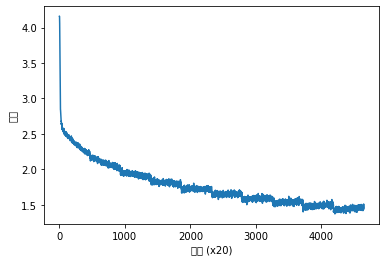

In [28]:
%matplotlib inline
trainer.plot()

In [29]:
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)



[query] you
 we: 0.7470703125
 i: 0.6845703125
 they: 0.611328125
 your: 0.578125
 anything: 0.541015625

[query] year
 month: 0.8564453125
 summer: 0.796875
 spring: 0.76513671875
 week: 0.76171875
 decade: 0.6982421875

[query] car
 luxury: 0.6396484375
 cars: 0.607421875
 window: 0.59326171875
 auto: 0.5810546875
 truck: 0.57763671875

[query] toyota
 mazda: 0.6396484375
 honda: 0.6220703125
 minicomputers: 0.5986328125
 chevrolet: 0.59228515625
 kellogg: 0.591796875
--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.91015625
 woman: 5.31640625
 daffynition: 4.640625
 ducks: 4.62109375
 naczelnik: 4.48828125

[analogy] take:took = go:?
 eurodollars: 4.54296875
 came: 4.2421875
 're: 4.03125
 began: 3.96484375
 were: 3.91015625

[analogy] car:cars = child:?
 a.m: 6.5078125
 rape: 5.48046875
 children: 5.15625
 incest: 5.11328125
 bond-equivalent: 4.90625

[analogy] good:better = bad:?
 more: 4.90234375
 rather: 4.78515625
 less: 4.61328125
 grea

In [30]:
word_vecs

array([[-0.2517  , -0.11865 ,  0.02481 , ...,  0.3037  ,  0.015144,
         0.01753 ],
       [-0.3196  , -0.2108  ,  0.02884 , ...,  0.2837  ,  0.02946 ,
        -0.05798 ],
       [-0.3308  , -0.3086  ,  0.10626 , ...,  0.4065  ,  0.0258  ,
        -0.0959  ],
       ...,
       [ 0.465   ,  0.57    ,  0.207   , ..., -0.5654  , -0.7954  ,
         0.0456  ],
       [-0.5894  ,  0.4636  , -1.313   , ...,  0.7876  , -0.695   ,
         0.303   ],
       [-0.2048  ,  0.4778  , -0.3328  , ..., -0.1183  , -0.977   ,
         0.10846 ]], dtype=float16)

In [31]:
out_vecs

array([[ 0.45125577,  0.19073516, -1.7458916 , ..., -1.0279448 ,
         0.9772538 ,  1.1724087 ],
       [ 0.63001883,  0.3794182 , -1.6764654 , ..., -0.96463555,
         0.89193594,  1.1288333 ],
       [ 0.5355185 ,  0.24366046, -1.6907034 , ..., -0.9867988 ,
         1.037043  ,  0.98993427],
       ...,
       [ 0.81544393,  0.7651316 , -0.8956716 , ..., -0.8496846 ,
         0.10857709,  0.9054017 ],
       [ 0.21572834,  0.5310535 , -2.2553644 , ..., -0.33689615,
         0.5397595 ,  1.3000083 ],
       [ 0.5569222 ,  0.80446666, -0.93478376, ..., -0.12326013,
         0.08863558,  0.7862375 ]], dtype=float32)

In [37]:
in_vec = open("in-vec.tsv", 'w', encoding='utf-8')
out_vec = open("out-vec.tsv", 'w', encoding='utf-8')
meta = open("meta.tsv", 'w', encoding='utf-8')

for word, idx in word_to_id.items():
    in_emb = word_vecs[idx]
    out_emb = out_vecs[idx]
    in_vec.write('\t'.join([str(x) for x in in_emb]) + '\n')
    out_vec.write('\t'.join([str(x) for x in out_emb]) + '\n')
    meta.write(word + '\n')

in_vec.close()
out_vec.close()
meta.close()

[tensorboard](http://projector.tensorflow.org/)

### 3-2. Skip-Gram 모델...

In [ ]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None
